## Bird Classifier

Data generator와 data spliter에서 만든 data를 토대로 학습한 classifier

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [3]:
batch_size = 16
img_height = 150
img_width = 150

train_ds = tf.keras.utils.image_dataset_from_directory(
  './data/train',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  './data/val',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  './data/test',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 320 files belonging to 4 classes.
Found 38 files belonging to 4 classes.
Found 44 files belonging to 4 classes.


In [4]:
train_ds.class_names

['crane', 'ibis', 'seagull', 'wildgoose']

In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
normalization_layer = layers.Rescaling(1./255)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

# load the ResNet-50 network, ensuring the head FC layer sets are left
# off
print("[INFO] preparing model...")
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(img_height, img_width, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2, 2), strides=(1, 1))(headModel)
headModel = Flatten(name="flatten")(headModel)
#headModel = Dense(1024, activation="softmax")(headModel)
#headModel = Dropout(0.2)(headModel)
headModel = Dense(len(class_names), activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

[INFO] preparing model...


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/30


c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


20/20 [==============================] - 9s 74ms/step - loss: 1.9098 - accuracy: 0.4625 - val_loss: 1.3704 - val_accuracy: 0.5000
Epoch 2/30
20/20 [==============================] - 0s 22ms/step - loss: 0.3491 - accuracy: 0.8719 - val_loss: 0.7645 - val_accuracy: 0.7368
Epoch 3/30
20/20 [==============================] - 0s 22ms/step - loss: 0.1038 - accuracy: 0.9719 - val_loss: 0.7904 - val_accuracy: 0.7632
Epoch 4/30
20/20 [==============================] - 0s 22ms/step - loss: 0.0465 - accuracy: 1.0000 - val_loss: 0.7883 - val_accuracy: 0.7632
Epoch 5/30
20/20 [==============================] - 0s 22ms/step - loss: 0.0206 - accuracy: 1.0000 - val_loss: 0.7738 - val_accuracy: 0.7895
Epoch 6/30
20/20 [==============================] - 0s 22ms/step - loss: 0.0161 - accuracy: 1.0000 - val_loss: 0.7568 - val_accuracy: 0.8158
Epoch 7/30
20/20 [==============================] - 0s 22ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.7650 - val_accuracy: 0.7895
Epoch 8/30
20/20 [======

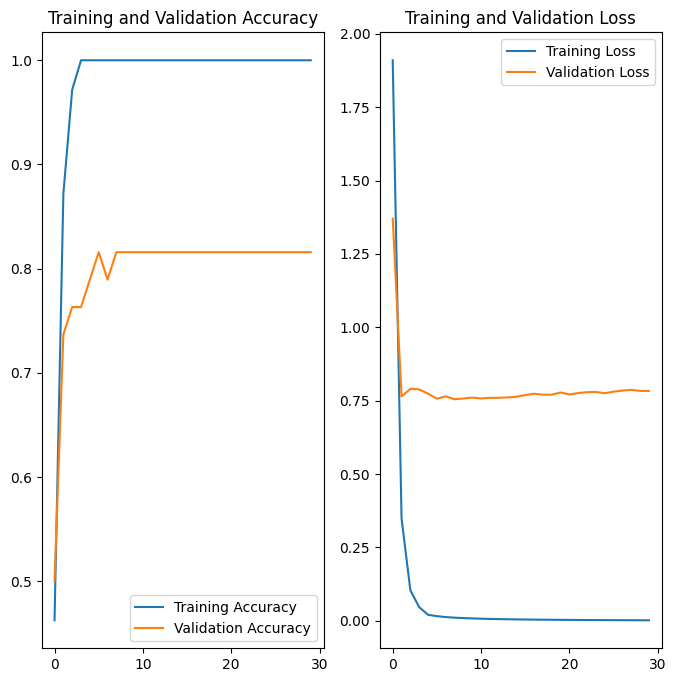

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

3/3 [==============================] - 1s 216ms/step - loss: 0.6201 - accuracy: 0.8409


{'loss': 0.620083212852478, 'accuracy': 0.8409090638160706}

In [13]:
from tensorflow.python.keras.models import load_model
model.save('bird_classifier.h5')

c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
